In [1]:
%load_ext autoreload

In [2]:
%autoreload 
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
import utilities as ut

Start h2o client

In [3]:
h2o.init(max_mem_size='6G')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21); OpenJDK 64-Bit Server VM JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21, mixed mode)
  Starting server from /Users/henrik/anaconda3/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1d/b_59w_9j0kx4nzfn4hkp84lc0000gn/T/tmpk88rjgr3
  JVM stdout: /var/folders/1d/b_59w_9j0kx4nzfn4hkp84lc0000gn/T/tmpk88rjgr3/h2o_henrik_started_from_python.out
  JVM stderr: /var/folders/1d/b_59w_9j0kx4nzfn4hkp84lc0000gn/T/tmpk88rjgr3/h2o_henrik_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.4
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_henrik_e1a13s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### Load FE data


In [6]:
X_train = pd.read_csv('X_train_new_features.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test_new_features.csv')

In [7]:
# set date_foercast as index
X_train.set_index('date_forecast', inplace=True)
y_train.set_index('date_forecast', inplace=True)
X_test.set_index('date_forecast', inplace=True)

In [43]:
X_train.head()

,diffuse_rad:W,historical_avg_solar_rad,absolute_humidity_2m:gm3,fresh_snow_12h:cm,cloudiness_duration,wind_speed_difference,visibility:m,sun_elevation:d,air_density_2m:kgm3,sun_azimuth:d,...,wind_speed_u_10m:ms,effective_cloud_cover:p,cloud_base_agl:m,pressure_100m:hPa,fresh_snow_3h:cm,elevation:m,year,day_of_year,relative_humidity_1000hPa:p,season
date_forecast,,,,,,,,,,,,,,,,,,,,,
2019-09-04 08:00:00,66.4,NaN,6.9,0.0,7.2,1.0,45762.0,23.775,1.231,124.573,...,-0.3,0.3,2103.1,996.4,0.0,7.0,2019,247,66.1,summer
2019-09-04 08:00:00,66.4,NaN,6.8,0.0,7.2,1.0,48151.2,23.775,1.226,124.572,...,-0.3,0.3,2104.0,996.5,0.0,6.0,2019,247,66.1,summer
2019-09-04 08:00:00,66.1,NaN,6.7,0.0,7.2,1.3,48379.1,23.796,1.223,124.555,...,-0.4,0.2,2122.7,993.9,0.0,24.0,2019,247,63.5,summer
2019-09-04 09:00:00,73.2,NaN,6.7,0.0,2066.4,1.4,48919.8,28.732,1.225,140.278,...,-1.3,43.0,2476.5,995.5,0.0,7.0,2019,247,58.8,summer
2019-09-04 09:00:00,73.2,NaN,6.7,0.0,2066.4,1.4,51142.4,28.732,1.220,140.277,...,-1.3,43.0,2478.4,995.6,0.0,6.0,2019,247,58.8,summer


In [8]:
X_train_h2o = h2o.H2OFrame(X_train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [9]:
X_test_h2o = h2o.H2OFrame(X_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [11]:
X_test_h2o.tail()

diffuse_rad:W,historical_avg_solar_rad,absolute_humidity_2m:gm3,fresh_snow_12h:cm,cloudiness_duration,wind_speed_difference,visibility:m,sun_elevation:d,air_density_2m:kgm3,sun_azimuth:d,ceiling_height_agl:m,solar_exposure,wind_speed_u_10m:ms,effective_cloud_cover:p,cloud_base_agl:m,pressure_100m:hPa,fresh_snow_3h:cm,elevation:m,year,day_of_year,relative_humidity_1000hPa:p,season
0,0.08,9.1,0,2400,2,39574.3,-3.469,1.207,355.318,2015.8,0,1.6,100,1537.3,980.9,0,6,2023,184,82.5,summer
0,0.04,9,0,2400,2,40071.4,-3.556,1.207,358.786,2015.2,0,1.6,100,1473.6,980.8,0,7,2023,184,82.8,summer
0,0.04,9,0,2400,1.7,39081.3,-3.594,1.207,358.782,2005.5,0,1.6,100,1346.9,978.9,0,24,2023,184,84.4,summer
0,0,9.1,0,2400,2,39627.2,-3.556,1.208,358.785,2015.7,0,1.6,100,1471.4,981,0,6,2023,184,82.8,summer
0,0,8.9,0,2400,1.7,39145.1,-3.579,1.207,2.25,2005.5,0,1.6,100,1222.8,979,0,24,2023,184,84.8,summer
0,0,9,0,2400,2,39691.8,-3.541,1.208,2.253,2015.6,0,1.6,100,1405.5,981,0,6,2023,184,83.2,summer
0,0,9,0,2400,2,40138.1,-3.54,1.207,2.253,2015,0,1.6,100,1408.6,980.9,0,7,2023,184,83.1,summer
0,0,9,0,2400,1.9,40204.5,-3.423,1.207,5.719,2014.9,0,1.6,100,1343.6,981,0,7,2023,184,83.5,summer
0,0,9,0,2400,1.9,39768.8,-3.424,1.208,5.718,2015.6,0,1.6,100,1339.6,981.1,0,6,2023,184,83.5,summer
0,0,8.9,0,2400,1.7,39217.6,-3.462,1.207,5.716,2005.5,0,1.6,100,1098.7,979.1,0,24,2023,184,85.1,summer


In [12]:
db = pd.concat([X_train, y_train], axis=1)
# remove duplicate columns
db = db.loc[:,~db.columns.duplicated()]

In [13]:
db_h20 = h2o.H2OFrame(db)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [14]:
y = "pv_measurement"

x = list(db_h20.columns)
x.remove(y)

In [15]:
x

['diffuse_rad:W',
 'historical_avg_solar_rad',
 'absolute_humidity_2m:gm3',
 'fresh_snow_12h:cm',
 'cloudiness_duration',
 'wind_speed_difference',
 'visibility:m',
 'sun_elevation:d',
 'air_density_2m:kgm3',
 'sun_azimuth:d',
 'ceiling_height_agl:m',
 'solar_exposure',
 'wind_speed_u_10m:ms',
 'effective_cloud_cover:p',
 'cloud_base_agl:m',
 'pressure_100m:hPa',
 'fresh_snow_3h:cm',
 'elevation:m',
 'year',
 'day_of_year',
 'relative_humidity_1000hPa:p',
 'season']

In [16]:
db_h20.head()

diffuse_rad:W,historical_avg_solar_rad,absolute_humidity_2m:gm3,fresh_snow_12h:cm,cloudiness_duration,wind_speed_difference,visibility:m,sun_elevation:d,air_density_2m:kgm3,sun_azimuth:d,ceiling_height_agl:m,solar_exposure,wind_speed_u_10m:ms,effective_cloud_cover:p,cloud_base_agl:m,pressure_100m:hPa,fresh_snow_3h:cm,elevation:m,year,day_of_year,relative_humidity_1000hPa:p,season,pv_measurement
66.4,nan,6.9,0,7.2,1,45762,23.775,1.231,124.573,2103.1,317.58,-0.3,0.3,2103.1,996.4,0,7,2019,247,66.1,summer,570.112
66.4,nan,6.8,0,7.2,1,48151.2,23.775,1.226,124.572,2104,317.58,-0.3,0.3,2104,996.5,0,6,2019,247,66.1,summer,3786.2
66.1,nan,6.7,0,7.2,1.3,48379.1,23.796,1.223,124.555,2122.7,318.72,-0.4,0.2,2122.7,993.9,0,24,2019,247,63.5,summer,137.2
73.2,nan,6.7,0,2066.4,1.4,48919.8,28.732,1.225,140.278,2476.5,399.04,-1.3,43,2476.5,995.5,0,7,2019,247,58.8,summer,542.512
73.2,nan,6.7,0,2066.4,1.4,51142.4,28.732,1.22,140.277,2478.4,399.04,-1.3,43,2478.4,995.6,0,6,2019,247,58.8,summer,3400.76
72.4,nan,6.5,0,1984.8,1.2,51497.8,28.761,1.217,140.26,2564.5,401.18,-1.2,41.3,2564.5,993,0,24,2019,247,55.8,summer,0
94.5,nan,6.2,0,2212.8,2.5,53565,32.223,1.213,157.124,2733.4,432.6,-2.4,46.1,2733.4,994.5,0,6,2019,247,51.7,summer,2620.86
94.5,nan,5.9,0,2212.8,2,53653.4,32.258,1.21,157.111,2869.8,434.1,-2,46.1,2869.8,991.9,0,24,2019,247,49.1,summer,0
94.5,nan,6.3,0,2212.8,2.6,51362.8,32.223,1.219,157.125,2731.2,432.6,-2.4,46.1,2731.2,994.4,0,7,2019,247,51.7,summer,460.575
162.5,nan,5.8,0,2400,2,54501.1,33.89,1.205,174.827,3173.3,364.9,-2,50,3173.3,991.3,0,24,2019,247,44.2,summer,0


## Run AutoML

In [17]:
# %%time
aml = H2OAutoML(seed=1, stopping_metric='MAE')
aml.train(x=x, y=y, training_frame=db_h20)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),13/68
# GBM base models (used / total),4/27
# XGBoost base models (used / total),9/33
# DRF base models (used / total),0/2
# DeepLearning base models (used / total),0/5
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [18]:
lb = aml.leaderboard
lb.head(rows=15)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_3_AutoML_1_20231015_170155,231.768,53716.5,76.3275,nan,53716.5
StackedEnsemble_AllModels_4_AutoML_1_20231015_170155,231.826,53743.3,76.385,nan,53743.3
StackedEnsemble_BestOfFamily_4_AutoML_1_20231015_170155,234.828,55144.2,75.1967,nan,55144.2
StackedEnsemble_BestOfFamily_5_AutoML_1_20231015_170155,236.35,55861.3,75.4507,nan,55861.3
StackedEnsemble_AllModels_2_AutoML_1_20231015_170155,239.951,57576.7,78.6049,nan,57576.7
StackedEnsemble_AllModels_1_AutoML_1_20231015_170155,240.009,57604.3,78.6125,nan,57604.3
GBM_grid_1_AutoML_1_20231015_170155_model_5,240.21,57700.7,76.2509,nan,57700.7
XGBoost_grid_1_AutoML_1_20231015_170155_model_19,240.351,57768.6,79.5444,nan,57768.6
StackedEnsemble_BestOfFamily_3_AutoML_1_20231015_170155,241.122,58139.8,79.0353,nan,58139.8
StackedEnsemble_BestOfFamily_2_AutoML_1_20231015_170155,241.138,58147.4,78.8604,nan,58147.4


In [19]:
aml.leader #Best model

key,value
Stacking strategy,cross_validation
Number of base models (used / total),13/68
# GBM base models (used / total),4/27
# XGBoost base models (used / total),9/33
# DRF base models (used / total),0/2
# DeepLearning base models (used / total),0/5
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [22]:
best_model_stacked = h2o.get_model(aml.leaderboard[0,'model_id'])

In [24]:
best_model = h2o.get_model('GBM_grid_1_AutoML_1_20231015_170155_model_5')

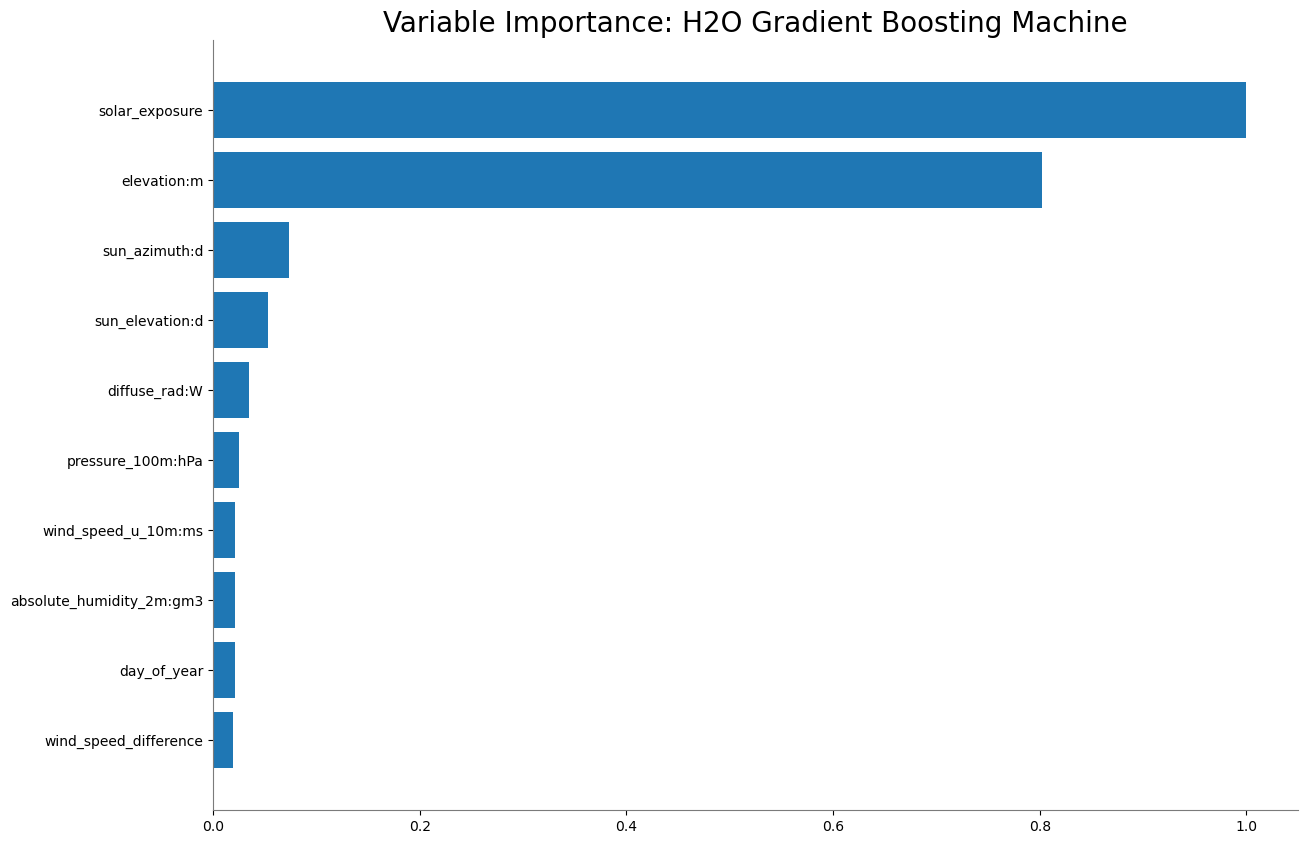

<Figure size 640x480 with 0 Axes>

In [27]:
best_model.varimp_plot()

In [28]:
pred_stacked = best_model_stacked.predict(X_test_h2o)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [29]:
pred = best_model.predict(X_test_h2o)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [30]:
pred.shape

(8640, 1)

In [31]:
pred_stacked_pd = pred_stacked.as_data_frame()
pred_pd = pred.as_data_frame()

In [32]:
results = pd.concat([X_test.reset_index(), pred_pd], axis=1)
results_stacked = pd.concat([X_test.reset_index(), pred_stacked_pd], axis=1)

In [33]:
# convert date_forecast to datetime and set as index
results['date_forecast'] = pd.to_datetime(results['date_forecast'])
results.set_index('date_forecast', inplace=True)
results_stacked['date_forecast'] = pd.to_datetime(results_stacked['date_forecast'])
results_stacked.set_index('date_forecast', inplace=True)

In [38]:
# replace all negative values in predict column with 0
results['predict'] = results['predict'].apply(lambda x: 0 if x < 0 else x)
results_stacked['predict'] = results_stacked['predict'].apply(lambda x: 0 if x < 0 else x)

In [40]:
results

,diffuse_rad:W,historical_avg_solar_rad,absolute_humidity_2m:gm3,fresh_snow_12h:cm,cloudiness_duration,wind_speed_difference,visibility:m,sun_elevation:d,air_density_2m:kgm3,sun_azimuth:d,...,effective_cloud_cover:p,cloud_base_agl:m,pressure_100m:hPa,fresh_snow_3h:cm,elevation:m,year,day_of_year,relative_humidity_1000hPa:p,season,predict
date_forecast,,,,,,,,,,,,,,,,,,,,,
2023-05-01 00:00:00,0.0,NaN,4.4,0.0,1936.7999,4.0,30210.7,-11.185,1.286,10.520,...,80.7,1041.2,1000.7,0.0,6.0,2023,121,80.3,spring,0.000000
2023-05-01 00:00:00,0.0,NaN,4.3,0.0,1936.7999,4.0,31329.5,-11.184,1.283,10.521,...,80.7,1039.9,1000.6,0.0,7.0,2023,121,80.3,spring,0.000000
2023-05-01 00:00:00,0.0,NaN,4.2,0.0,1768.7999,3.5,31411.0,-11.223,1.286,10.519,...,73.7,1178.0,998.2,0.0,24.0,2023,121,81.1,spring,0.000000
2023-05-01 00:15:00,0.0,NaN,4.3,0.0,1848.0000,4.0,30003.6,-10.825,1.287,14.203,...,77.0,1054.8,1000.6,0.0,6.0,2023,121,80.3,spring,0.000000
2023-05-01 00:15:00,0.0,NaN,4.3,0.0,1850.3999,4.0,31181.6,-10.824,1.283,14.204,...,77.1,1053.1,1000.5,0.0,7.0,2023,121,80.3,spring,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-03 23:30:00,0.0,0.0,9.0,0.0,2400.0000,2.0,39691.8,-3.541,1.208,2.253,...,100.0,1405.5,981.0,0.0,6.0,2023,184,83.2,summer,1.290622
2023-07-03 23:30:00,0.0,0.0,9.0,0.0,2400.0000,2.0,40138.1,-3.540,1.207,2.253,...,100.0,1408.6,980.9,0.0,7.0,2023,184,83.1,summer,109.630954
2023-07-03 23:45:00,0.0,0.0,9.0,0.0,2400.0000,1.9,40204.5,-3.423,1.207,5.719,...,100.0,1343.6,981.0,0.0,7.0,2023,184,83.5,summer,109.630954


In [41]:
# rename predict column to pv_prediction
results.rename(columns={'predict': 'pv_prediction'}, inplace=True)
results_stacked.rename(columns={'predict': 'pv_prediction'}, inplace=True)
ut.save_to_csv(results, 'H2O_AutoML_Predictions_3')
ut.save_to_csv(results_stacked, 'H2O_AutoML_Predictions_Stacked_3')